## Selecting targets for visual re-inspection
### BGS - tile 6603

This notebook will merge the truth tables with Andes redrock files and select targets that need to be re-inspected, according to the following criteria:

- Redrock z changed between original and new;
- Redrock chisq or delta chisq changed by a large amount.
- New Redrock z disagrees with visual inspections;
- New Redrock Spec type differs from VI;
- The VI flag was < 2.5. **N.B: I changed this to <= 2.5**


In [1]:
import os, sys, glob
import numpy as np

from astropy.io import fits
from astropy.table import Table, join, vstack
from astropy.io import fits

import pandas as pd
import fnmatch

import desispec.io

sys.path.append("/global/homes/r/rtojeiro/SV/python")
import VI_utils as VI

import matplotlib.pyplot as plt 

pd.set_option('display.max_rows', 50)

In [2]:
tiledir_andes='/global/cfs/cdirs/desi/spectro/redux/andes/tiles/'
tiledir = '/global/cfs/cdirs/desi/spectro/redux/daily/tiles/'
tile = '66003'
date = '20200315'
spectrograph = ['0','1', '2', '3', '4', '5', '6' ,'7', '8', '9']

In [3]:
save_filename = 'BGS_reinspection_66003.csv'

### Read in truth table

In [4]:
full_filename = 'truth_table_BGS_v1.2.csv'
truth_table = pd.read_csv(os.environ['TT_DIR']+'/'+full_filename)
#convert from pandas DataFrame to astropy Table for ease later
#truth_table = Table.from_pandas(df)

In [5]:
truth_table.keys()

Index(['TARGETID', 'Redrock z', 'best z', 'best quality', 'Redrock spectype',
       'best spectype', 'all VI issues', 'all VI comments', 'merger comment',
       'N_VI', 'DELTACHI2', 'ZWARN', 'ZERR', 'FIBER', 'FLUX_G', 'FLUX_R',
       'FLUX_Z', 'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z',
       'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z'],
      dtype='object')

First, add chi2 from the original reductions, as we never added that to the truth tables

In [6]:
#read in zbest info, loop over the files for all the spectrographs
tspec = Table.read(tiledir+'/'+tile + '/'+date+'/zbest-'+str(spectrograph[0])+'-'+str(tile)+'-'+date+'.fits',hdu='ZBEST')
for i in range(1,len(spectrograph)):
    tn = Table.read(tiledir+'/'+tile + '/'+date+'/zbest-'+str(spectrograph[i])+'-'+str(tile)+'-'+date+'.fits',hdu='ZBEST')
    tspec = vstack([tspec,tn])

tspec_df = tspec['TARGETID','CHI2'].to_pandas()

truth_table = truth_table.merge(tspec_df, how='left', on='TARGETID')

In [7]:
truth_table.keys()

Index(['TARGETID', 'Redrock z', 'best z', 'best quality', 'Redrock spectype',
       'best spectype', 'all VI issues', 'all VI comments', 'merger comment',
       'N_VI', 'DELTACHI2', 'ZWARN', 'ZERR', 'FIBER', 'FLUX_G', 'FLUX_R',
       'FLUX_Z', 'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z',
       'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z', 'CHI2'],
      dtype='object')

Now add information from the Andes reductions: redshift, chi2, deltachi2, spectype and warning flags

In [8]:
#read in zbest info, loop over the files for all the spectrographs
tspec = Table.read(tiledir_andes+'/'+tile + '/'+date+'/zbest-'+str(spectrograph[0])+'-'+str(tile)+'-'+date+'.fits',hdu='ZBEST')
for i in range(1,len(spectrograph)):
    tn = Table.read(tiledir_andes+'/'+tile + '/'+date+'/zbest-'+str(spectrograph[i])+'-'+str(tile)+'-'+date+'.fits',hdu='ZBEST')
    tspec = vstack([tspec,tn])

tspec_df = tspec['TARGETID','Z','CHI2', 'DELTACHI2','ZWARN', 'ZERR', 'SPECTYPE' ].to_pandas()

tspec_df = tspec_df.rename(columns={"Z": "Z_andes"})
tspec_df = tspec_df.rename(columns={"CHI2": "CHI2_andes"})
tspec_df = tspec_df.rename(columns={"SPECTYPE": "SPECTYPE_andes"})

truth_table = truth_table.merge(tspec_df, how='left', on='TARGETID', suffixes=('', '_andes'))

In [9]:
truth_table.keys()

Index(['TARGETID', 'Redrock z', 'best z', 'best quality', 'Redrock spectype',
       'best spectype', 'all VI issues', 'all VI comments', 'merger comment',
       'N_VI', 'DELTACHI2', 'ZWARN', 'ZERR', 'FIBER', 'FLUX_G', 'FLUX_R',
       'FLUX_Z', 'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z',
       'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z', 'CHI2',
       'Z_andes', 'CHI2_andes', 'DELTACHI2_andes', 'ZWARN_andes', 'ZERR_andes',
       'SPECTYPE_andes'],
      dtype='object')

Text(0,0.5,'DELTACHI Andes')

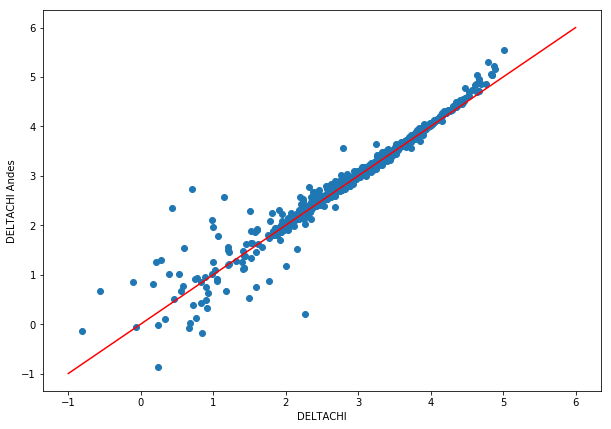

In [10]:
plt.figure(figsize=(10,7))
plt.scatter(np.log10(truth_table['DELTACHI2']), np.log10(truth_table['DELTACHI2_andes']))
plt.plot([-1,6], [-1,6], color='red')
plt.xlabel('DELTACHI')
plt.ylabel('DELTACHI Andes')

Text(0,0.5,'DELTACHI Andes')

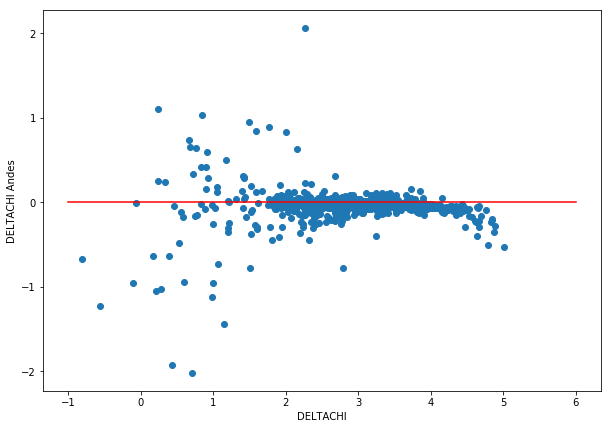

In [11]:
plt.figure(figsize=(10,7))
plt.scatter(np.log10(truth_table['DELTACHI2']), 
    (np.log10(truth_table['DELTACHI2'])-np.log10(truth_table['DELTACHI2_andes'])))
plt.plot([-1,6], [0,0], color='red')
plt.xlabel('DELTACHI')
plt.ylabel('DELTACHI Andes')

Text(0,0.5,'N')

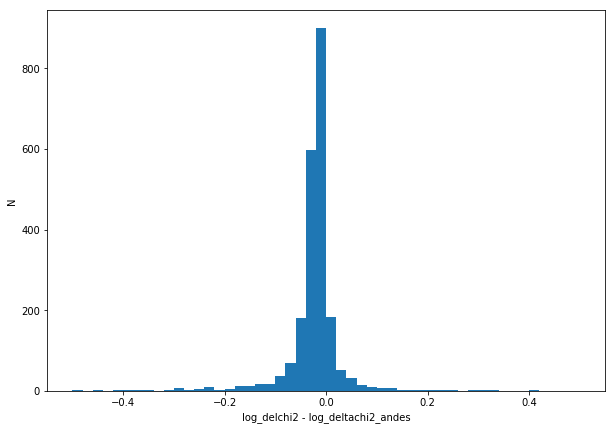

In [19]:
plt.figure(figsize=(10,7))
x=plt.hist(np.log10(truth_table['DELTACHI2'])-np.log10(truth_table['DELTACHI2_andes']), bins=50,
            range=(-0.5,0.5))
plt.xlabel('log_delchi2 - log_deltachi2_andes')
plt.ylabel('N')

I'm going to include everything for which log10_deltachi2 changed by more than 0.1 in absolute value

Text(0,0.5,'log CHI2 Andes')

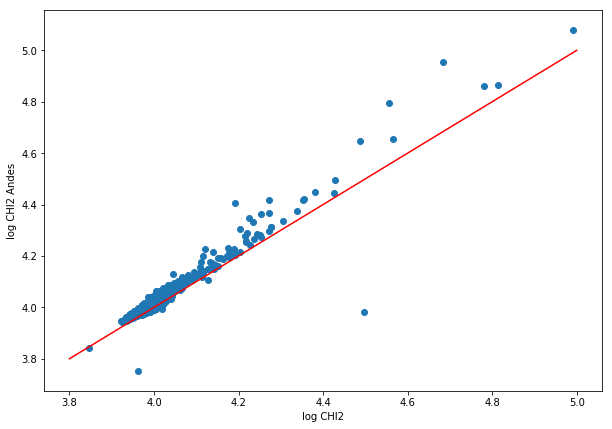

In [13]:
plt.figure(figsize=(10,7))
plt.scatter(np.log10(truth_table['CHI2']), np.log10(truth_table['CHI2_andes']))
plt.plot([3.8,5], [3.8,5], color='red')
plt.xlabel('log CHI2')
plt.ylabel('log CHI2 Andes')

Chi2 is generally higher in Andes, so I'm **not** going to include chi2 difference between original and Andes reductions in the criteria for re-inspection.

In [14]:
re_VI = truth_table[ \
            ((truth_table['Redrock z']-truth_table['Z_andes'])/(1+truth_table['Redrock z']) > 0.0033) | 
            ((truth_table['best z']-truth_table['Z_andes'])/(1+truth_table['best z']) > 0.0033) |
            (truth_table['best spectype'] != truth_table['SPECTYPE_andes']) |
            (truth_table['best quality'] <= 2.5) | 
            (np.abs(np.log10(truth_table['DELTACHI2'])-np.log10(truth_table['DELTACHI2_andes'])) > 0.1 )       
            ]
print(len(re_VI))

189


In [15]:
re_VI.keys()

Index(['TARGETID', 'Redrock z', 'best z', 'best quality', 'Redrock spectype',
       'best spectype', 'all VI issues', 'all VI comments', 'merger comment',
       'N_VI', 'DELTACHI2', 'ZWARN', 'ZERR', 'FIBER', 'FLUX_G', 'FLUX_R',
       'FLUX_Z', 'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z',
       'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z', 'CHI2',
       'Z_andes', 'CHI2_andes', 'DELTACHI2_andes', 'ZWARN_andes', 'ZERR_andes',
       'SPECTYPE_andes'],
      dtype='object')

In [16]:
re_VI[['best z', 'Redrock z', 'Z_andes', 'best quality', 'best spectype', 'SPECTYPE_andes']]

,best z,Redrock z,Z_andes,best quality,best spectype,SPECTYPE_andes
16,0.3414,0.3414,0.341389,4.000000,GALAXY,GALAXY
20,0.1638,0.1638,1.506403,1.000000,GALAXY,GALAXY
38,0.1646,0.1646,0.164635,4.000000,GALAXY,GALAXY
56,0.3100,0.3100,0.310036,4.000000,GALAXY,GALAXY
92,0.4292,0.4292,0.429248,3.666667,GALAXY,GALAXY
99,1.2489,1.2489,1.363550,0.000000,GALAXY,QSO
109,0.0650,0.0650,0.065030,4.000000,GALAXY,GALAXY
120,0.0974,0.0974,0.097407,4.000000,GALAXY,GALAXY
134,0.0913,0.4640,0.091337,1.000000,GALAXY,GALAXY
138,0.0631,0.0631,0.063133,4.000000,GALAXY,GALAXY


Save to file

In [17]:
re_VI['TARGETID'].to_csv(os.environ['TT_DIR']+save_filename, index=False, header=False)

In [18]:
re_VI['TARGETID']

16      35191341457606988
20      35191341457608318
38      35191341461802014
56      35191341465996155
92      35191341478577368
              ...        
2115    35191360105480318
2125    35191363096019097
2135    35191363104409484
2142    35191363104410851
2222    35191366107529267
Name: TARGETID, Length: 189, dtype: int64